In [2]:
import pandas as pd
from pycaret.classification import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# 데이터 로딩
match_data = pd.read_csv('/Users/lhe339/Documents/GitHub/nextorial/data/데이터 분석가_과제_Type A/match_data.csv')
test_data = pd.read_csv('/Users/lhe339/Documents/GitHub/nextorial/data/데이터 분석가_과제_Type A/test_data.csv')

In [4]:
class DataProcessor:
    
    def __init__(self, df):
        self.data = df

    @staticmethod
    def convert_tier_to_numeric(tier):
        tier_dict = {
            'unranked': 0,
            'bronze': 1,
            'silver': 2,
            'gold': 3,
            'platinum': 4,
            'diamond': 5,
            'master': 6
        }
        return tier_dict.get(tier, -1)

    # guild_membership
    def guild_avg(self):
        df = self.data.copy()
        df['guildid'].fillna('NoGuild', inplace=True)
        df['tier_numeric'] = df['tier'].map(self.convert_tier_to_numeric)
        guild_avg = df.groupby('guildid')[['mmr', 'winstreak', 'recentwinprob', 'accumatches', 'tier_numeric']].mean()
        new_columns = {col: f'{col}_guild_avg' for col in guild_avg.columns}
        guild_avg.rename(columns=new_columns, inplace=True)
        df = pd.merge(df, guild_avg, on='guildid', how='left')
        return df
    
    # high_mmr_guild
    def process_guild_info(self, threshold):
        guild_mean_mmr = self.data.groupby('guildid')['mmr'].mean()
        self.data['guild_mean_mmr'] = self.data['guildid'].map(guild_mean_mmr)
        self.data['high_mmr_guild'] = (self.data['guild_mean_mmr'] > threshold).astype(int)
        return self.data    
    
    def preprocess(self):
        self.data = self.guild_avg()
        self.data = self.process_guild_info(2000)



In [5]:
processor = DataProcessor(match_data)
processor.preprocess()
processed_data = processor.data

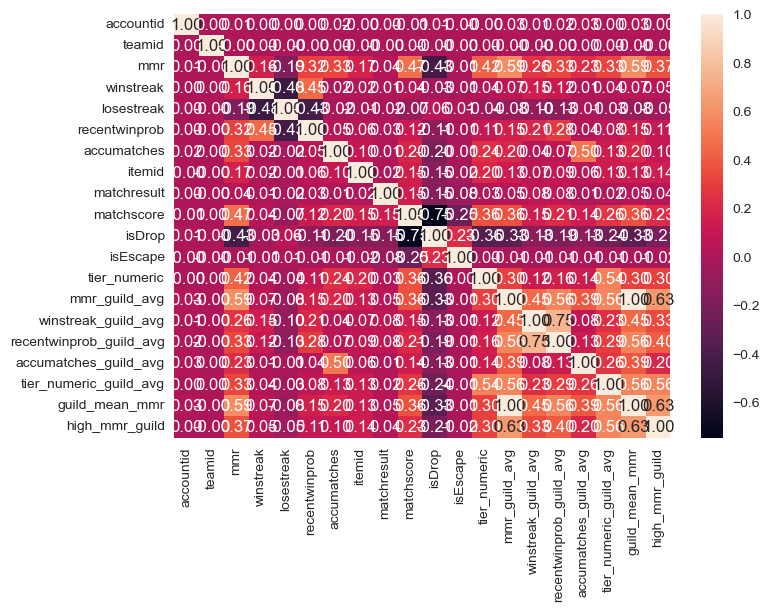

In [6]:
# 문자열 데이터를 포함하는 열을 제거
numeric_data = processed_data.select_dtypes(include=[np.number])

# 상관 행렬 계산
corr_matrix = numeric_data.corr()

plt.figure(figsize=(50, 40))

# 히트맵 표시
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={'size': 20})

# x와 y축의 레이블에 대한 글꼴 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [7]:
# PyCaret 설정
clf1 = setup(data = match_data,
             target = 'matchresult',
             ignore_features = ['createdatekst', 'matchid', 'accountid', 'guildid'],  # 무시할 특성
             ordinal_features = {'tier': ['unranked', 'bronze', 'silver', 'gold', 'platinum', 'diamond', 'master']},  # 순서형 특성
             session_id=123)  # 재현 가능성을 위한 세션 ID 설정

,Description,Value
0,Session id,123
1,Target,matchresult
2,Target type,Binary
3,Original data shape,"(410384, 16)"
4,Transformed data shape,"(410384, 18)"
5,Transformed train set shape,"(287268, 18)"
6,Transformed test set shape,"(123116, 18)"
7,Ignore features,4
8,Ordinal features,1
9,Numeric features,10


In [8]:
# 모델 비교
compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:18:57
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.5702,0.6028,0.6186,0.5640,0.5900,0.1404,0.1411,9.3670
ridge,Ridge Classifier,0.5620,0.0000,0.7084,0.5479,0.6179,0.1239,0.1296,0.5500
lr,Logistic Regression,0.5577,0.5893,0.6415,0.5494,0.5916,0.1153,0.1172,1.4890
nb,Naive Bayes,0.5541,0.5667,0.8023,0.5361,0.6427,0.1081,0.1245,0.4110
rf,Random Forest Classifier,0.5492,0.5728,0.5577,0.5484,0.5530,0.0985,0.0985,20.2490
qda,Quadratic Discriminant Analysis,0.5415,0.5634,0.7950,0.5286,0.6308,0.0829,0.1000,1.8310
knn,K Neighbors Classifier,0.5258,0.5342,0.5273,0.5258,0.5265,0.0517,0.0517,22.9400
dt,Decision Tree Classifier,0.5215,0.5214,0.5202,0.5215,0.5209,0.0429,0.0429,1.1580
svm,SVM - Linear Kernel,0.5156,0.0000,0.6544,0.4933,0.4692,0.0312,0.0480,11.4660


Processing:   0%|          | 0/61 [00:00<?, ?it/s]